In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import timeit
import river
import math
import os

# Clean Data

## July Data

## December Data

# Plot Data

## July Data

## December Data

# Z-Score New Data

In [ ]:
def isAnomaly(value,mean,std,tolerance):
    if float(std) == 0:
        return 0
    else:
        zscore = (value - mean) / std
        if zscore > tolerance:
            return 1
        else:
            return 0

# Set InfluxDB Connection

In [ ]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

In [ ]:
bucket = "riot"
org = "polimi"
token = "d2VsY29tZQ=="
url="http://35.152.63.133:8086"

client = influxdb_client.InfluxDBClient(
   url=url,
   token=token,
   org=org
)

query_api = client.query_api()

# Get parameters from API

In [ ]:
import hashlib
import requests
from requests import Request, Session
import time
import random

In [ ]:
def createAuth(username,method,uri):
    #auth1 = "user@host.com:" + username + ':' + password
    #hash_object = hashlib.md5(auth1.encode())
    #hash1 = hash_object.hexdigest().upper()
    hash1 = '7CC384C2A10CEA62FB2A37CFDA222C04'
    
    now = '{:8X}'.format(int(time.time()))    
    POOL = "ABCDEF0123456789"
    nonce_list = []
    for i in range(0,24):
        nonce_list.append(POOL[random.randint(0,len(POOL)-1)])
    nonce_str = ''.join(nonce_list)
    nonce = now + nonce_str
    
    auth2 = method + ':' + uri
    hash_object = hashlib.md5(auth2.encode())
    hash2 = hash_object.hexdigest().upper()
    
    auth3 = hash1 + ':' + nonce + ':' + hash2
    hash_object = hashlib.md5(auth3.encode())
    authority = hash_object.hexdigest().upper()
    
    return "oasis username=\"" + "service" + "\", nonce=\"" + nonce + "\", authority=\"" + authority + "\""

In [ ]:
method = 'GET'
uri = '/global' # use '/global' to access the variables, '/auth' only for the authentication
username = 'service'
BASE_URI = 'https://demo.riotsecure.io:6443'
headers = {
    'Authorization': createAuth(username,method,uri), 
    'Content-Type': "application/json",
    'Cache-Control': "no-cache"
}
print(headers)
body = {}

In [ ]:
if method == "GET":
    _uri = uri + "?expand"
    response = requests.get(BASE_URI + _uri, headers=headers)
elif method == "POST":
    response = requests.post(BASE_URI + _uri, headers=headers, json=body)


tolerance = 3
frequency = '-24h'    
    
if response.status_code == 200:
    #in console, print in stderror
    print("The request was a success!")
    print('The tolerance is ' + str(response.json()['keys']['net_anomoly']['tolerance']))
    print('The frequency is ' + str(response.json()['keys']['net_anomoly']['frequency']))
    #bisogna fare un controllo??
    tolerance = response.json()['keys']['net_anomoly']['tolerance']
    frequency = '-' + str(response.json()['keys']['net_anomoly']['frequency']) + 'h'
elif response.status_code == 404:
    print("Error 404")
elif response.status_code == 401:
    print("401: Unauthorized")

# Check new entries New Data

In [ ]:
tags = ['dst','dstp','service','src','srcp','url']

for tag in tags:
    path = 'anomaly_detector/dataset/lists/' + tag
    df = pd.read_csv(path + '.csv',header=0)
    l = df['_value'].tolist()
    #eseguito giornalieralmente, come parametro
    q = 'import "influxdata/influxdb/schema"\
        schema.tagValues(\
        bucket: "riot",\
        tag: "' + tag + '",\
        start: ' + frequency + ')'
    #system.exit(0)
    result = query_api.query(org=org, query=q)
    results = []
    for table in result:
        for record in table.records:
            results.append((record.get_value()))
    diffs = list(set(results) - set(l))
    if len(diffs) != 0:
        #call API
        print('*** New ' + tag + ' ***')
        for diff in diffs:
            #print(diff)
            new_row = {'_value': diff}
            df = df.append(new_row, ignore_index=True)
    df.to_csv(path + '.csv',index=False)

# Check new Anomalies z-score

In [ ]:
def checkNewHash(hash_table,diff_hash):
    if hash_table in diff_hash:
        return 1
    else:
        return 0

In [ ]:
def updateStatsDict(stats_dict,df):
    actual_hash = list(stats_dict.keys())
    new_hash = df['hash_table'].unique().tolist()
    diff_hash = list(set(new_hash) - set(actual_hash))    
    stats = pd.DataFrame()
    stats['avg_diff'] = df.groupby('hash_table')['_value_diff'].mean()
    stats['std_diff'] = df.groupby('hash_table')['_value_diff'].std()  
    stats['cnt_diff'] = df.groupby('hash_table')['_value_diff'].size()
    stats['ss_diff'] = df.groupby('hash_table')['_value_diff_squared'].sum()
    stats = stats[stats.index.isin(diff_hash)]
    new_stats_dict = stats.T.to_dict('list')
    stats_dict.update(new_stats_dict)
    df['new_hash'] = df.apply(lambda row: checkNewHash(row['hash_table'],diff_hash),axis=1)
    return stats_dict,df

In [ ]:
measurements = ['tdmp_bytes_created','tdmp_bytes_total','tdmp_packets_created','tdmp_packets_total']

for m in measurements:
    path = 'anomaly_detector/dataset/stats/' + m
    stats_dict = pd.read_csv(path + '.csv',header=0).set_index('hash_table').T.to_dict('list')
    s = pd.read_csv('anomaly_detector/dataset/lists/service.csv',header=0)
    services = s['_value'].tolist()
    f = ''
    for service in services:
        if service == services[-1]:
            f += 'r["service"] == "' + service + '"'
        else:
            f += 'r["service"] == "' + service + '" or '
    #eseguito giornalieralmente, come parametro
    q = 'from(bucket: "' + bucket + '")\
      |> range(start: ' + frequency + ')\
      |> filter(fn: (r) => r["_measurement"] == "' + m + '")\
      |> filter(fn: (r) => ' + f + ')'
    result = query_api.query(org=org, query=q)
    results = []
    for table in result:
        for record in table.records:
            results.append([record.values.get("_time"),record.values.get("dst"),record.values.get("dstp"),record.values.get("proto"),record.values.get("service"),record.values.get("src"),record.values.get("srcp"),record.values.get("url"), record.get_value()])
    df = pd.DataFrame(results,columns=['_time','dst', 'dstp', 'proto','service','src','srcp','url','_value'])
    df['_value_diff'] = df['_value'].diff()
    df['_value_diff_squared'] = df['_value_diff'].pow(2)
    df['hash_table'] = df.apply(lambda row: row['dst'] + '_' + row['dstp'] + '_' + row['proto'] + '_' + row['service'] + '_' + row['src'] + '_' + row['srcp'] + '_' + row['url'],axis=1)
    stats_dict,df = updateStatsDict(stats_dict,df)
    df['anomaly_diff'] = df.apply(lambda row: isAnomaly(row['_value_diff'],stats_dict[row['hash_table']][0],stats_dict[row['hash_table']][1],tolerance),axis=1)
    anomalies = df.loc[df['anomaly_diff'] == 1]
    if anomalies.shape[0] != 0:
        #call API POST
        print('*** Anomalies in ' + m + ' ***')        
        anomalies_drop = anomalies.drop(['_value_diff_squared','new_hash','anomaly_diff'], axis=1)
        anomalies_drop.index.names = ['uuid']
        if os.stat('anomaly_detector/dataset/anomalies/' + m + '.csv').st_size == 0:            
            anomalies_drop.to_csv('anomaly_detector/dataset/anomalies/' + m + '.csv',index=True)
        else:        
            existing_anomalies = pd.read_csv('anomaly_detector/dataset/anomalies/' + m + '.csv').append(anomalies_drop, ignore_index = True)
            existing_anomalies.to_csv('anomaly_detector/dataset/anomalies/' + m + '.csv',index=True)
    normalities = df.loc[(df['anomaly_diff'] == 0) & (df['new_hash'] == 0)]
    if normalities.shape[0] != 0:
        for index, row in normalities.iterrows():
            stat = stats_dict[row['hash_table']]
            #avg += (value-avg)/n 
            stat[0] += (row['_value_diff'] - stat[0]) / stat[2]
            stat[3] += math.pow(row['_value_diff'],2)
            stat[2] += 1
            #std = sqrt((1/(n-1)*(ss-(avg.pow(2)/n))))
            stat[1] = math.sqrt((1 / (stat[2]-1)) * (stat[3] - (math.pow(stat[0],2) / stat[2])))
            stats_dict[row['hash_table']] = stat
    pd.DataFrame.from_dict(stats_dict,orient='index').reset_index().rename(columns={'index':'hash_table', 0:'avg_diff', 1:'std_diff', 2:'cnt_diff', 3:'ss_diff'}).to_csv(path + '.csv',index=False)


# Process Data

In [ ]:
# Define metrics to use

# più grande è, meglio è
def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
        # if (s_unif >= u).sum() > n_generated / 1000:
        EM_t = np.maximum(EM_t, 1. / n_samples * (s_X > u).sum() -
                          t * (s_unif > u).sum() / n_generated
                          * volume_support)
    amax = np.argmax(EM_t <= t_max) + 1
    if amax == 1:
        print ('\n failed to achieve t_max \n')
        amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax


# più piccolo è, meglio è
def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        # pdb.set_trace()
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt  # sum(s_X > u)
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv


In [ ]:
n_generated = 100000
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.9
ocsvm_max_train = 10000
np.random.seed(1)

In [ ]:
def split_df(df):    
    df['_time'] = pd.to_datetime(df['_time']).astype(np.int64) / int(1e6)
    encoder = OneHotEncoder(handle_unknown='ignore')
    ohencDf = df.copy()
    encoding = pd.DataFrame(encoder.fit_transform(ohencDf[["dst","dstp","proto","src","srcp","url"]]).toarray())
    ohencDf = ohencDf.drop(["dst","dstp","proto","src","srcp","url"],axis=1)
    ohencDf = ohencDf.join(encoding)
    n_train = int(ohencDf.shape[0] * 0.8)
    train = np.array(ohencDf.head(n_train))
    test = (ohencDf.tail(ohencDf.shape[0]-n_train))
    return ohencDf,np.array(train),np.array(test)

In [ ]:
def calculate_parameters(df):
    lim_inf = np.array(df).min(axis=0)
    lim_sup = np.array(df).max(axis=0)
    volume_support = (lim_sup - lim_inf).prod()
    volume_support = volume_support if volume_support > 1 else 1
    t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
    axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
    unif = np.random.uniform(lim_inf, lim_sup,size=(n_generated, df.shape[1]))
    return t,volume_support,axis_alpha,unif

In [ ]:
def evaluate_model(model,train,test,unif,reshape=False):
    model.fit(train)
    s_X_model = model.decision_function(test)
    s_unif_model = model.decision_function(unif)
    if reshape:
        #model.fit(train[:min(ocsvm_max_train, n_samples_train - 1)])
        s_X_model = s_X_model.reshape(1, -1)[0]
        s_unif_model = s_unif_model.reshape(1, -1)[0]                           
    return s_X_model,s_unif_model

In [ ]:
def calculate_metrics(t,volume_support,s_unif_model,s_X_model,axis_alpha):
    auc_em_model,em_model,amax_model = em(t, t_max,volume_support,s_unif_model,s_X_model,n_generated)
    auc_mv_model,mv_model = mv(axis_alpha,volume_support,s_unif_model, s_X_model,n_generated)
    return auc_em_model,em_model,amax_model,auc_mv_model,mv_model

In [ ]:
def plot(path,title,t,amax,em_iforest,mv_iforest,auc_em_iforest,auc_mv_iforest,em_lof,mv_lof,auc_em_lof,auc_mv_lof,em_ocsvm,mv_ocsvm,auc_em_ocsvm,auc_mv_ocsvm,axis_alpha):
    plt.clf()    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
    fig.suptitle(title,fontsize=25,y=1.05)    

    ax1.plot(t[:amax], em_iforest[:amax], lw=1,label='%s (em_score = %0.3e)'% ('iforest', auc_em_iforest))
    ax1.plot(t[:amax], em_lof[:amax], lw=1,label='%s (em-score = %0.3e)'% ('lof', auc_em_lof))
    ax1.plot(t[:amax], em_ocsvm[:amax], lw=1,label='%s (em-score = %0.3e)'% ('ocsvm', auc_em_ocsvm))
    ax1.set_xlabel('t',fontsize=20)
    ax1.set_ylabel('EM(t)',fontsize=20)
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Excess-Mass curve', fontsize=20)
    ax1.legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),fancybox=True)

    ax2.plot(axis_alpha, mv_iforest, lw=1,label='%s (mv-score = %0.3e)'% ('iforest', auc_mv_iforest))
    ax2.plot(axis_alpha, mv_lof, lw=1,label='%s (mv-score = %0.3e)'% ('lof', auc_mv_lof))
    ax2.plot(axis_alpha, mv_ocsvm, lw=1,label='%s (mv-score = %0.3e)'% ('ocsvm', auc_mv_ocsvm))    
    ax2.set_xlabel('alpha', fontsize=20)
    ax2.set_ylabel('MV(alpha)', fontsize=20)
    ax2.set_title('Mass-Volume Curve', fontsize=20)
    ax2.legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),fancybox=True)
    
    fig.subplots_adjust(wspace=0.4)
    #plt.show()
    plt.tight_layout()
    plt.savefig(path + 'EM_MV_plot.png',bbox_inches='tight')

In [ ]:
files = ['2021-04-01_2021-05-01_clean','2021-05-01_2021-06-01_clean','2021-06-01_2021-07-01_clean','2021-07-01_2021-08-01_clean']

for value in values:
    for service in services:
        title = value + ' ' + service
        print(title)
        path = 'dataset/' + value + '/' + service + '/'
        df = pd.DataFrame()
        for file in files:            
            try:
                f = pd.read_csv(path + file + '.csv',header=0).sort_values(by='_time',ascending=True)                
                df = pd.concat([df,f],axis=0,ignore_index=True)                
            except:
                continue        
        df_tot,df_train,df_test = split_df(df)
        t,volume_support,axis_alpha,unif = calculate_parameters(df_tot)
        start = timeit.default_timer()
        s_X_iforest,s_unif_iforest = evaluate_model(IsolationForest(),df_train,df_test,unif)
        s_X_lof,s_unif_lof = evaluate_model(LocalOutlierFactor(n_neighbors=20,novelty=True),df_train,df_test,unif)
        s_X_ocsvm,s_unif_ocsvm = evaluate_model(OneClassSVM(),df_train,df_test,unif,True)
        stop = timeit.default_timer()
        print('Time: ', stop - start)
        auc_em_iforest,em_iforest,amax_iforest,auc_mv_iforest,mv_iforest = calculate_metrics(t,volume_support,s_unif_iforest,s_X_iforest,axis_alpha)
        auc_em_lof,em_lof,amax_lof,auc_mv_lof,mv_lof = calculate_metrics(t,volume_support,s_unif_lof,s_X_lof,axis_alpha)
        auc_em_ocsvm,em_ocsvm,amax_ocsvm,auc_mv_ocsvm,mv_ocsvm = calculate_metrics(t,volume_support,s_unif_ocsvm,s_X_ocsvm,axis_alpha)
        if amax_iforest == -1 or amax_lof == -1 or amax_ocsvm == -1:
            amax = -1
        else:
            amax = max(amax_iforest, amax_lof, amax_ocsvm)
        plot(path,title,t,amax,em_iforest,mv_iforest,auc_em_iforest,auc_mv_iforest,em_lof,mv_lof,auc_em_lof,auc_mv_lof,em_ocsvm,mv_ocsvm,auc_em_ocsvm,auc_mv_ocsvm,axis_alpha)
        

# Streaming Anomaly Detector

In [2]:
from river import anomaly
from river import compose
from river import metrics
from river import preprocessing
from sklearn.preprocessing import LabelEncoder

In [3]:
measurements = ['tdmp_bytes_created','tdmp_bytes_total','tdmp_packets_created','tdmp_packets_total']

In [4]:
from river import datasets

In [ ]:
for m in measurements:
    model = compose.Pipeline(
        #preprocessing.MinMaxScaler(),
        #anomaly.OneClassSVM(nu=0.2))
        anomaly.HalfSpaceTrees(seed=42))
    train = pd.read_csv('anomaly_detector/dataset/' + m + '.csv')
    y = train['anomaly_diff']
    train = train.drop(['_time','_value','dstp','hash_table','_value_diff_squared','anomaly_diff'], axis=1)
    for column in train:
        if column != '_value_diff':
            le = LabelEncoder()
            train[column] = le.fit_transform(train[column])
    auc = metrics.ROCAUC()
    for index, row in train.iterrows():
        row = row.fillna(0)
        x = row.to_dict()
        score = model.score_one(x)
        model = model.learn_one(x)
        auc = auc.update(y[index], score)
    print(str(auc) + ' ' + m)

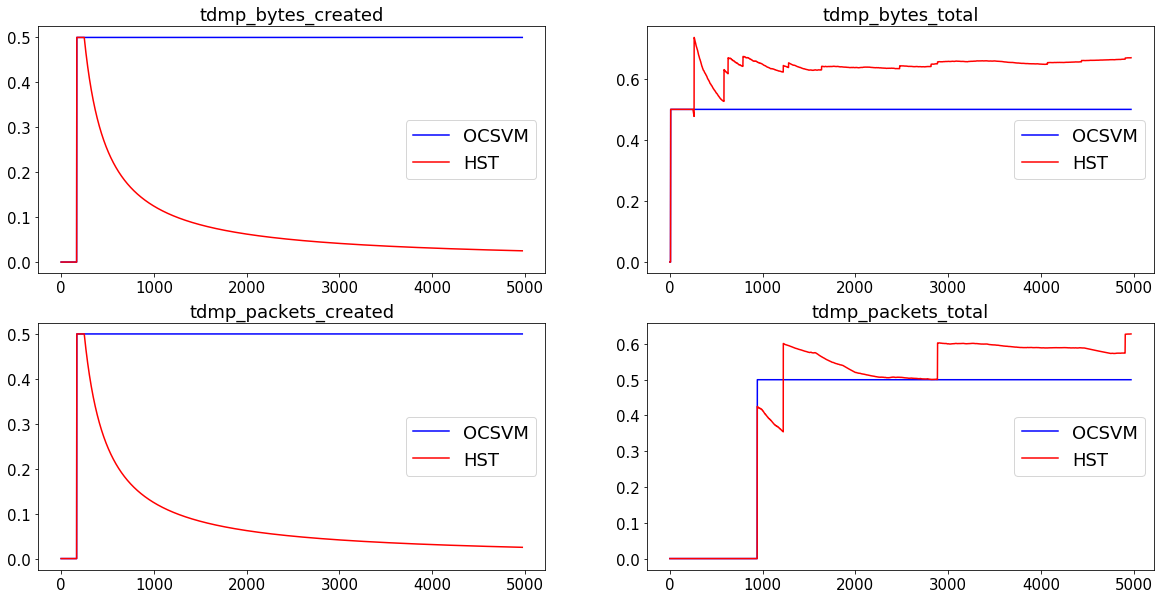

In [33]:
r = 0
c = 0
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(2, 2, figsize=(20,10))
for m in measurements:
    auc_ocsvm = []
    auc_hst = []
    auc1 = metrics.ROCAUC()
    auc2 = metrics.ROCAUC()
    model1 = compose.Pipeline(
        preprocessing.MinMaxScaler(),
        anomaly.QuantileThresholder(anomaly.OneClassSVM(nu=0.1),q=0.995))
    model2 = compose.Pipeline(
        preprocessing.MinMaxScaler(),
        anomaly.HalfSpaceTrees(seed=42))
    train = pd.read_csv('anomaly_detector/dataset/' + m + '.csv')
    y = train['anomaly_diff']
    train = train['_value_diff']
    for index, row in train.iteritems():
        x = {'x': row}
        score1 = model1.score_one(x)
        model1 = model1.learn_one(x)
        score2 = model2.score_one(x)
        model2 = model2.learn_one(x)
        auc1 = auc1.update(y[index], score1)
        auc2 = auc2.update(y[index], score2)
        auc_ocsvm.append(auc1.get())
        auc_hst.append(auc2.get())
    axs[r, c].plot(range(len(auc_ocsvm)), auc_ocsvm, c='b', label='OCSVM')
    axs[r, c].plot(range(len(auc_hst)), auc_hst, c='r', label='HST')
    axs[r, c].set_title(m, fontsize="large")
    axs[r, c].legend(loc='center right', fontsize="large")
    #if c == 1 and r == 1:
        #handles, labels = axs[r,c].get_legend_handles_labels()
    c += 1
    if c == 2:
        r +=1
        c = 0
    
#fig.legend(handles, labels, loc='upper center')
#axs.set_xlabel(fontsize="large")    